# About this notebook...
this notebook is basically a copy of [SRK's notebook](https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author/notebook) about this [kaggle playground dataset Spooky](https://www.kaggle.com/c/spooky-author-identification),  
__But in korean__ 

# 개요
spooky를 검색하면 '으스스한, 귀신이 나올 것 같은'의 비격식적 표현이라고 합니다. 데이터셋은 세 작가의 글을 답고 있는데 두명은 유명한 공포/미스터리 소설가라 저도 알고 있고 나머지 한 명은 누군지 모르겠습니다. 아마 비슷한 장르이겠죠? 아무튼 세 작가는  
EAP (에드거 앨런 포), HPL(HP 러브크래프트), MWS(매리 울스톤크래프트 셸레이)  
이며, competition의 목표는 문장이 누구의 것인지 맞추는 것입니다.

이 노트북에서는 다른 feature들을 만들어 보겠다고 하고, 일단 데이터를 살펴보며 cleaning을 합니다.

# 기초적인 시각화와 데이터 정제 (cleaning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

자주 보지 못했던 라이브러리 등은 다음과 같습니다.  
- sklearn.decomposition.TrauncatedSVD
- pd.options.mode.chained_assignment

## train, test 데이터셋을 불러와서 직접 살펴봅니다.

In [2]:
import os
path = "../input/spooky-author-identification/"
train_df = pd.read_csv(os.path.join(path, 'train.zip'))
test_df = pd.read_csv(os.path.join(path, 'test.zip'))
print(train_df.shape[0], test_df.shape[0])

19579 8392


zip 파일인데 왜 csv라고 해놨을까요? 아무튼 pandas.read_csv()는 zip파일도 잘 읽어들입니다.

In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


label이 어떻게 분포돼있는지 살펴봅니다.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


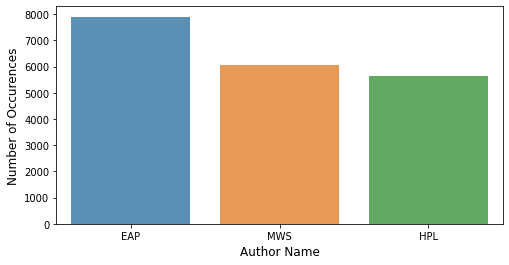

In [5]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize = 12)
plt.xlabel('Author Name', fontsize = 12)
plt.show()

크게 차이 나지는 않습니다. 몇 줄을 직접 들여다봅니다. 이 부분은 iteration을 굳이 쓰지 않도록 고쳤습니다.

In [6]:
_ = train_df[train_df['author']=='EAP'].sample(5)['text'].apply(print)

"No? Well; the disclosure of the document to a third person, who shall be nameless, would bring in question the honor of a personage of most exalted station; and this fact gives the holder of the document an ascendancy over the illustrious personage whose honor and peace are so jeopardized."
I at once offered to purchase it of the landlord; but this person made no claim to it knew nothing of it had never seen it before.
There was no American money.
His manner at these moments was frigid and abstract; his eyes were vacant in expression; while his voice, usually a rich tenor, rose into a treble which would have sounded petulantly but for the deliberateness and entire distinctness of the enunciation.
And when did the radiant Una ask anything of her Monos in vain?


In [7]:
_ = train_df[train_df['author']=='HPL'].sample(5)['text'].apply(print)

I mention his talk about angles because it suggests something Wilcox had told me of his awful dreams.
Yog Sothoth is the key and guardian of the gate.
That evening, after a day of hurried cabling and arranging, I bade my host adieu and took a train for San Francisco.
And I have read more of these things, and of many things besides, in the books men gave me when I was young and filled with wonder.
All day I forged steadily westward, guided by a far away hummock which rose higher than any other elevation on the rolling desert.


In [8]:
_ = train_df[train_df['author']=='MWS'].sample(5)['text'].apply(print)

She died on the first approach of cold weather, at the beginning of this last winter.
I beseech you; by your former love for me now lost, I adjure you to answer that one question.
There does not exist the man in England with adequate presumption.
But this catalogue of favourites to be taken with us, could not be made without grief to think of our heavy losses, and a deep sigh for the many things we must leave behind.
But you will, I hope, soon quit this melancholy abode, for doubtless evidence can easily be brought to free you from the criminal charge."


In [9]:
del _

제가 영어 문체를 따질 정도로 영어에 능숙한지 모르겠습니다. 아무튼 MWS가 가장 구어체에 가깝고 HPL과 EAP는 쉼표와 절을 복잡하게 넣는 경향이 있습니다. EAP는 절의 길이가 짧은 것이 눈에 띕니다. 이런 것은 글에 긴박감과 속도감을 줍니다. 그런데 다섯 문장 정도 보고 분석하긴 어렵겠네요. 이 노트북의 SRK님도 혹시 문장들 보고 특징을 알겠으면 좀 알려달라고 써놨습니다.

# Feature Engineering:  

## meta feature: 
텍스트 자체에서 뽑아낸, 단어 수, 불용어 수, 구두점 수 등  
1. 텍스트 내에 단어의 수
2. 텍스트 내에 고유한 단어 수 (단어의 종류가 몇인가)
3. 텍스트 내의 문자 수
4. 불용어의 수
5. 구두점의 수
6. 대문자의 수
7. title case: 제목에서 모든 단어를 대문자로 표기하는 방법

## 텍스트 기반 feature:  
 직접적으로 어떤 단어가 들어가 있냐 하는 것에 관한 것. frequency, SVD, word2vect 등  

In [10]:
#number of words in the text
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))

#Number of unique words in the text
train_df["num_unique_words"] = \
    train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = \
    test_df["text"].apply(lambda x: len(set(str(x).split())))

#number of characters in the text
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

#number of stopwords in the text
train_df["num_stopwords"] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#number of punctuations in the text
def num_punc(text): return len([c for c in str(text) if c in string.punctuation])
train_df['num_punctuations'] = train_df['text'].apply(num_punc)
test_df['num_punctuations'] = test_df['text'].apply(num_punc)

#number of upper case words in the text
def num_upper(s): return len([w for w in str(s).split() if w.isupper()])
train_df['num_words_upper'] = train_df['text'].apply(num_upper)
test_df['num_words_upper'] = test_df['text'].apply(num_upper)

#number of title case words in the text
def num_words_title(s): return len([w for w in str(s).split() if w.istitle()])
train_df['num_words_title'] = train_df['text'].apply(num_words_title)
test_df['num_words_title'] = test_df['text'].apply(num_words_title)


#average length of the ords in the text
def mean_word_len(s): return np.mean([len(w) for w in str(s).split()])
train_df['mean_word_len'] = train_df['text'].apply(mean_word_len)
test_df['mean_word_len'] = test_df['text'].apply(mean_word_len)




In [11]:
train_df.head()

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481


이제 새 변수들을 쓸모가 있을지 보자고 하네요. 그러면서 80이상의 'num_words'를 80으로 바꿉니다?

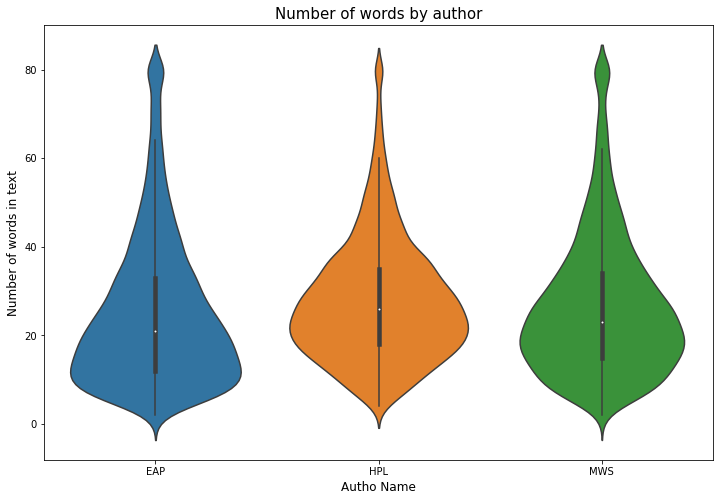

In [12]:
#it cannot change the values in dataframe!! use loc() method
#train_df[train_df['num_words']>80]['num_words'] = 80

train_df['num_words'].loc[train_df['num_words']>80] = 80

plt.figure(figsize = (12, 8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Autho Name', fontsize = 12)
plt.ylabel('Number of words in text', fontsize = 12)
plt.title('Number of words by author', fontsize = 15)
plt.show()

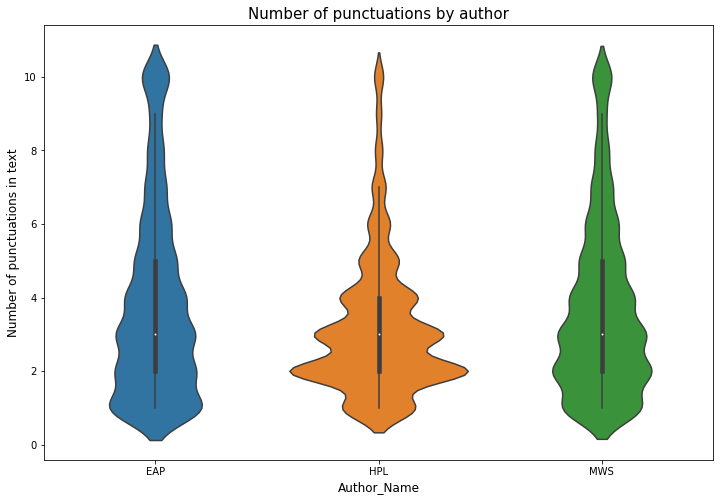

In [13]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10
plt.figure(figsize = (12, 8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author_Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize = 12)
plt.title('Number of punctuations by author', fontsize = 15)
plt.show()

텍스트 기반 feature를 생성합니다. meta features가 어떻게 쓸모가 있는지 보기 위해 basic model을 만들어 봅시다.

In [14]:
#prepare the data for modeling
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# recompute the truncated variables again
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))
train_df['mean_word_len'] = train_df['text'].apply(mean_word_len)
test_df['mean_word_len'] = test_df['text'].apply(mean_word_len)

#drop columns
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis = 1)
test_X = test_df.drop(cols_to_drop, axis = 1)

XGBoost model with meta features

In [15]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample = 0.3):
    param={'objective':'multi:softprob',
          'eta':0.1,
          'max_depth':3,
          'silent':1,
          'num_class':3,
          'eval_metric':"mlogloss",
          'min_child_weight':child,
          'subsample':0.8,
          'colsample_bytree':colsample,
          'seed':seed_val}
    num_rounds = 2000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds = 50, verbose_eval = 20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
    
    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

실행시간이 꽤 되기 때문에 첫 번째 스코어만 확인합니다. (Break를 풀라고도 하네요. 어디서 그러라는 것인지?

In [16]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

In [17]:

for dev_index, val_index in kf.split(train_X): 
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

print('cv scores : ', cv_scores)


[03:12:26] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.09242	test-mlogloss:1.09321


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[20]	train-mlogloss:1.04163	test-mlogloss:1.05206
[40]	train-mlogloss:1.02159	test-mlogloss:1.03705
[60]	train-mlogloss:1.00633	test-mlogloss:1.02497
[80]	train-mlogloss:0.99540	test-mlogloss:1.01691
[100]	train-mlogloss:0.98804	test-mlogloss:1.01233
[120]	train-mlogloss:0.98099	test-mlogloss:1.00796
[140]	train-mlogloss:0.97523	test-mlogloss:1.00485
[160]	train-mlogloss:0.97026	test-mlogloss:1.00214
[180]	train-mlogloss:0.96549	test-mlogloss:0.99993
[200]	train-mlogloss:0.96126	test-mlogloss:0.99812
[220]	train-mlogloss:0.95772	test-mlogloss:0.99691
[240]	train-mlogloss:0.95440	test-mlogloss:0.99581
[260]	train-mlogloss:0.95070	test-mlogloss:0.99442
[280]	train-mlogloss:0.94753	test-mlogloss:0.99339
[300]	train-mlogloss:0.94429	test-mlogloss:0.99274
[320]	train-mlogloss:0.94176	test-mlogloss:0.99259
[340]	train-mlogloss:0.93856	test-mlogloss:0.99157
[360]	train-mlogloss:0.93625	test-mlogloss:0.99123
[380]	train-mlogloss:0.93373	test-mlogloss:0.99055
[400]	train-mlogloss:0.93154	test-m

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


## 코드/결과 확인
- KFold model에서 split(train_X)
- warning: ntree_limit is deprecated ?
- loss function?  

mlogloss가 0.989로 나왔는데 노트북의 0.987과 거의 같습니다. 이 중 어떤 feature가 중요했는지 따져봅니다.

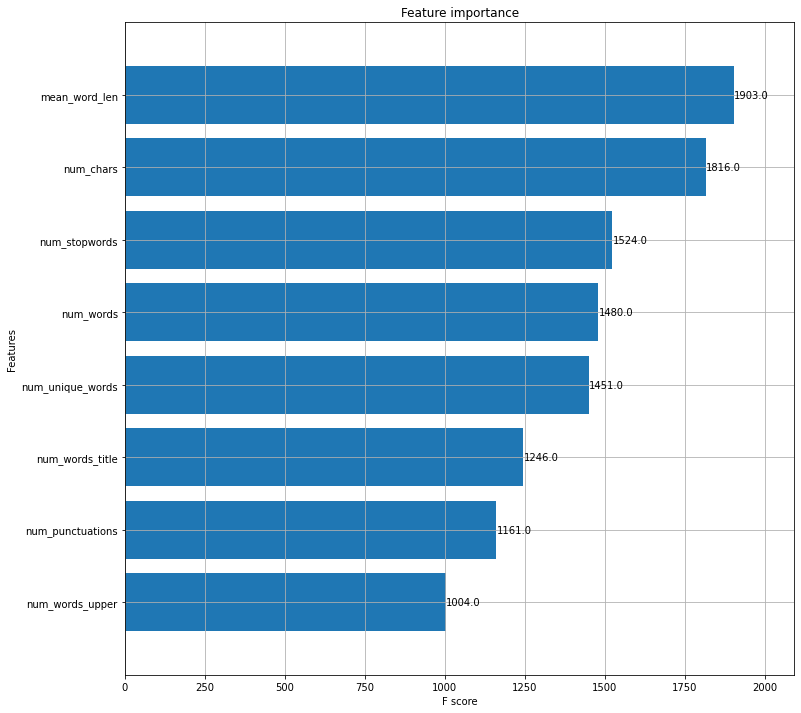

In [18]:
#plot the important variables
fig, ax = plt.subplots(figsize = (12, 12))
xgb.plot_importance(model, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

메타 feature 중에서는 문자 수, 평균 단어 길이, 고유 단어수가 가장 중요했답니다. 이제 text based feature를 만들어보자고 해요.

### text based features
tf-idf같은 기본적인 feature에서 시작합니다.

In [19]:
tfidf_vec = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

__Questions__ TfidfVectorizer의 method들이 많은데 뭐하는 것일까? fit_transform과 transform은 어떤 차이가 있을까?

이러한 sparse matrix를 다른 dense feature처럼 써먹으려면 두 방법이 있다고 합니다.
- top 'n' feature 만 넣기 (기준이 뭘까요?)
- sparse matrix만을 쓰는 model을 만들고, prediction을 다른 feature들처럼 씀  
데이터셋에 따라 어떤 것이 좋을지 다른데, 여기서는 'tf-idf 벡터 전체를 쓰고 좋은 점수를 얻은 커널이 있기 때문에' 두 번째 방법을 쓴다고 합니다. 그리고 naive-bayes model이 좋은 성능을 보여주고 그건 빠르게 돌아가니까 tf-idf용으로 naive-bayes를 쓴다고 해요.

In [20]:
def runMNB(train_X, train_y, test_X, test_y, test_X2): #multinomial naive-bayes
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

Naive Bayes on word tfidf vectorizer

In [21]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits = 5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean CV score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean CV score :  0.8422161983612855


m_log_loss가 0.84로 meta-feature만 사용했을 때보다 좋아졌답니다. 그런데 mlogloss가 뭘까요? 기억이 잘 안나네요. 다음으로는 confusion matrix입니다. confusion matrix는 뭘까요? 다른게 아니라 label true/false, predicted

In [23]:
# function to create confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

# below - copied
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

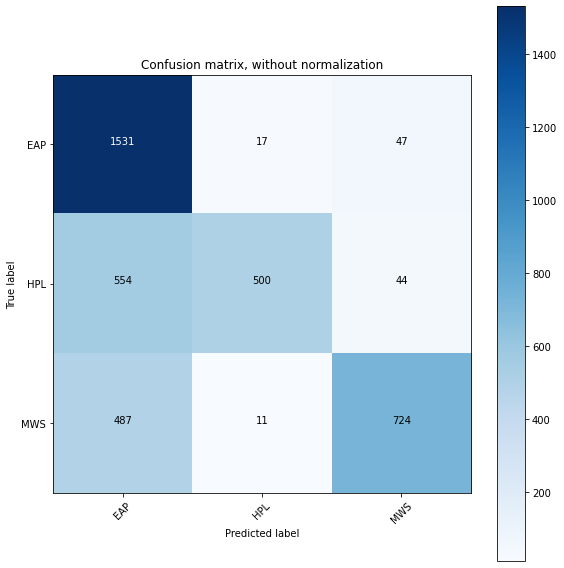

In [25]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

#non-normalized confusion matrix (Q: what is normalized confusion matrix)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                     title = 'Confusion matrix, without normalization')
plt.show()

EAP로 심하게 편향돼 있고, 예측값이 엄청 많이 나왔습니다.

### SVD on word TF-IDF
SVD를 통해 sparse한 tfidf 벡터를 간단하게 만들 수 있고, 자기가 최근에 했던 competition에서도 이게 좋았기 때문에 해본다고 합니다.
Q)SVD가 뭐였죠?

In [27]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm = 'arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis = 1)
test_df = pd.concat([test_df, test_svd], axis = 1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

### Naive Bayes on word count vectorizer

In [37]:
tfidf_vec = CountVectorizer(stop_words = 'english', ngram_range=(1, 3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

build multinomial NB on word count vectorizer

In [38]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

#add the predictions as new features
train_df['nb_cvec_eap'] = pred_train[:,0]
train_df['nb_cvec_hp1'] = pred_train[:,1]
train_df['nb_cvec_mws'] = pred_train[:,2]
test_df['nb_cvec_eap'] = pred_full_test[:,0]
test_df['nb_cvec_hp1'] = pred_full_test[:,1]
test_df['nb_cvec_mws'] = pred_full_test[:,2]


Mean cv score :  0.45091841616567435


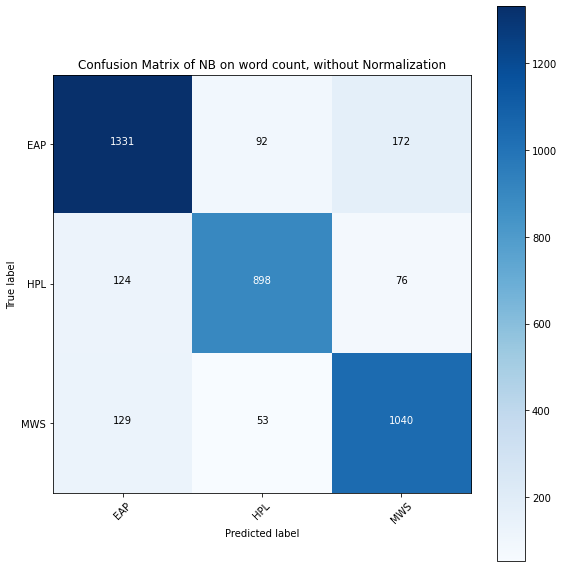

In [39]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision = 2)

#below - copied
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

#non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                     title = 'Confusion Matrix of NB on word count, without Normalization')
plt.show()
#below - copied


metrics - log loss가 0.451까지 내려가고, confusion matrix도 훨씬 좋아졌다고 합니다.

### Naive Bayes on word character count vectorizer
이것 등등 다양한 feature를 추가해서 이걸 0.305까지 낮추는데 생략합시다.